Import packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np # numerical array processing
import argparse # parse the argument
import cv2 # opencv bindings

Display function for notebooks

In [2]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [3]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/littoral-combat-ship.jpg", # path to input image to detect against
	"prototxt": "MobileNetSSD_deploy.prototxt.txt", # model definition file of the SSD network
	"model": "MobileNetSSD_deploy.caffemodel", # model is the actual weights of the SSD
	"confidence": 0.8 # used to filter out weak detections, less than 20% drop it...tune this
}

In [4]:
# this is an important list
# background class isn't used, but the model needs to model the background
# so it can ignore it, but it has to know what it is
# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
# bounding boxes will get a unique color for each class for the length of the classes list (ex. 20)
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
print("[INFO] loading model...")
# download the deep neural network (dnn) from Caffe
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
# (note: normalization is done via the authors of the MobileNet SSD
# implementation)
image = cv2.imread(args["image"])
(h, w) = image.shape[:2]
# when you load an image from disk and want to pass through a NN, you need to blob it...need to learn more on this
# blackbox pre-processing technique for now
# 300x300 is required for MobileNet input
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

[INFO] loading model...


In [5]:
# pass the blob through the network and obtain the detections and
# predictions
print("[INFO] computing object detections...")
# set the blob as input to the NN
net.setInput(blob)
# forwardpass the image through the NN, detect outside the network
detections = net.forward()

[INFO] computing object detections...


[INFO] boat: 87.17%
[INFO] aeroplane: 81.85%


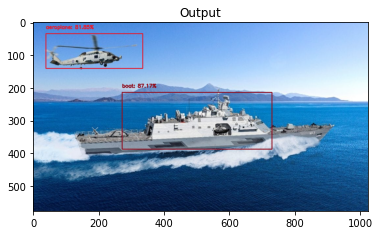

In [6]:
# loop over the detections
for i in np.arange(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence from the CLI argument
	if confidence > args["confidence"]:
		# extract the index of the class label from the `detections`,
		idx = int(detections[0, 0, i, 1])
		# then compute the (x, y)-coordinates of the bounding box for
		# the object, because we resized the image we rescale back to the original dimensions
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# this is the entire detection process

		# display the prediction
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))
		cv2.rectangle(image, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(image, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

# show the output image
plt_imshow("Output", image)